In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras import layers, models
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from tqdm.notebook import tqdm


In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()

x_train = x_train.astype("float32") / 255.0
x_test = x_test.astype("float32") / 255.0
y_train = y_train.flatten()
y_test = y_test.flatten()

170498071/170498071 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [2]:
def build_autoencoder():
    encoder = models.Sequential([
        layers.Input(shape=(32, 32, 3)),
        layers.Conv2D(32, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Conv2D(64, 3, activation='relu', padding='same'),
        layers.MaxPooling2D(2),
        layers.Flatten(),
        layers.Dense(2)
    ])

    decoder = models.Sequential([
        layers.Input(shape=(2,)),
        layers.Dense(8*8*64, activation='relu'),
        layers.Reshape((8, 8, 64)),
        layers.Conv2DTranspose(64, 3, strides=2, padding='same', activation='relu'),
        layers.Conv2DTranspose(32, 3, strides=2, padding='same', activation='relu'),
        layers.Conv2D(3, 3, padding='same', activation='sigmoid')
    ])

    input_img = tf.keras.Input(shape=(32, 32, 3))
    encoded = encoder(input_img)
    decoded = decoder(encoded)
    autoencoder = tf.keras.Model(input_img, decoded)
    return autoencoder, encoder


In [5]:
autoencoder, encoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(x_train, x_train, epochs=20, batch_size=256, validation_data=(x_test, x_test))


Epoch 1/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - loss: 0.0501 - val_loss: 0.0377
Epoch 2/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0375 - val_loss: 0.0373
Epoch 3/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step - loss: 0.0372 - val_loss: 0.0372
Epoch 4/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0372 - val_loss: 0.0370
Epoch 5/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 22ms/step - loss: 0.0373 - val_loss: 0.0370
Epoch 6/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 23ms/step - loss: 0.0369 - val_loss: 0.0370
Epoch 7/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 24ms/step - loss: 0.0369 - val_loss: 0.0369
Epoch 8/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - loss: 0.0368 - val_loss: 0.0368
Epoch 9/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0368 - val_loss: 0.0368
Epoch 10/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 4s 21ms/step - loss: 0.0369 - val_loss: 0.0369
Epoch 11/20
196/196 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - loss: 0.0367 - val_loss: 0.0368
Epoch 12/20
196/196 ━━━━━━━━━━━━━━━━━━━━

313/313 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step


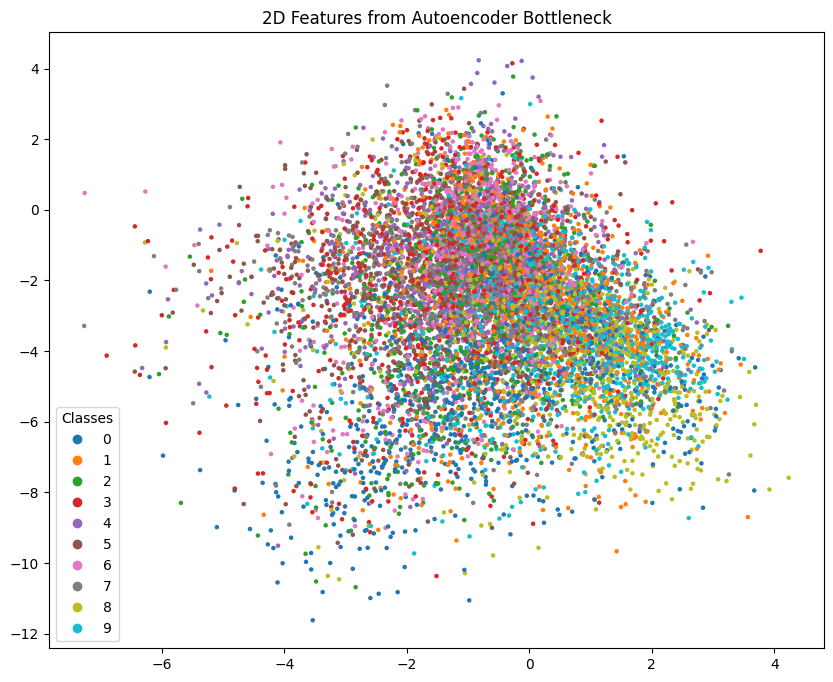

In [6]:
features_2d = encoder.predict(x_test)
plt.figure(figsize=(10, 8))
scatter = plt.scatter(features_2d[:, 0], features_2d[:, 1], c=y_test, cmap='tab10', s=5)
plt.legend(*scatter.legend_elements(), title="Classes")
plt.title("2D Features from Autoencoder Bottleneck")
plt.show()


In [10]:
base_model = tf.keras.applications.ResNet50(weights='imagenet', include_top=False, input_shape=(224, 224, 3), pooling='avg')
batch_size = 100
cnn_features = []
num_batches = len(x_test) // batch_size


for i in tqdm(range(num_batches)):
    start_index = i * batch_size
    end_index = (i + 1) * batch_size
    x_test_batch = x_test[start_index:end_index]
    x_test_resized_batch = tf.image.resize(x_test_batch, (224, 224))
    cnn_features_batch = base_model.predict(x_test_resized_batch)
    cnn_features.append(cnn_features_batch)
if len(x_test) % batch_size != 0:
    start_index = num_batches * batch_size
    x_test_batch = x_test[start_index:]
    x_test_resized_batch = tf.image.resize(x_test_batch, (224, 224))
    cnn_features_batch = base_model.predict(x_test_resized_batch)
    cnn_features.append(cnn_features_batch)

cnn_features = np.concatenate(cnn_features, axis=0)
pca = PCA(n_components=2)
features_pca = pca.fit_transform(cnn_features)

tsne = TSNE(n_components=2, perplexity=30)
features_tsne = tsne.fit_transform(cnn_features[:2000])
labels_subset = y_test[:2000]

  0%|          | 0/100 [00:00<?, ?it/s]

4/4 ━━━━━━━━━━━━━━━━━━━━ 11s 2s/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step 
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
4/4 ━━━━━━━━

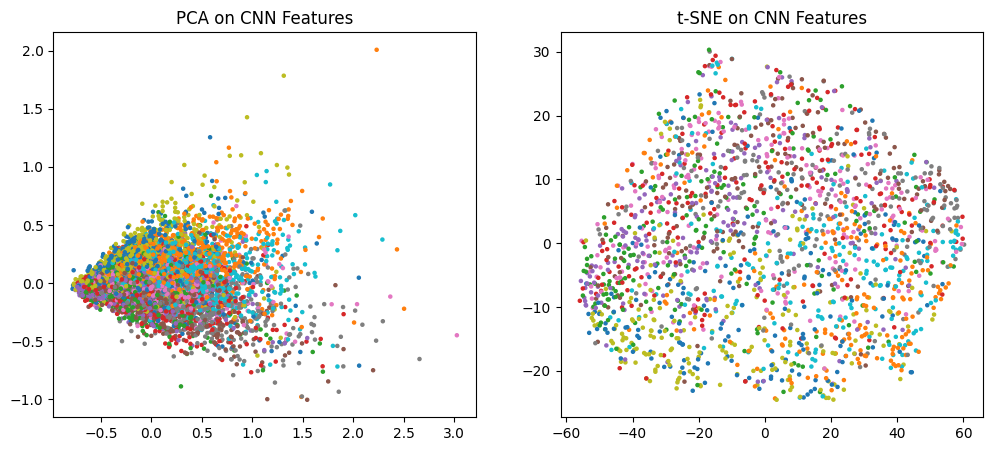

In [11]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(features_pca[:, 0], features_pca[:, 1], c=y_test, cmap='tab10', s=5)
plt.title("PCA on CNN Features")

plt.subplot(1, 2, 2)
plt.scatter(features_tsne[:, 0], features_tsne[:, 1], c=labels_subset, cmap='tab10', s=5)
plt.title("t-SNE on CNN Features")
plt.show()
